In [ ]:
# ---
# jupyter:

#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: hydrogen
#       format_version: '1.3'
#       jupytext_version: 1.15.2
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import inputools.Trajectory as it

import os
from copy import deepcopy

# os.chdir("lab/PCNN")
print(os.getcwd())
import src.models as mm
import src.minimal_model as minm
from src.utils import logger
import src.visualizations as vis
import src.utils as utils

from tools.utils import clf, tqdm_enumerate

%load_ext autoreload
%autoreload 2

plt.style.use('classic')
logger.info("")

2024-06-11 17:33:27 | 


In [ ]:
# --- TRAJECTORY
np.random.seed(2) # 1

Nj = 25**2
duration = 20

# make trajectory
bounds = (0, 1, 0, 1)
layer = it.PlaceLayer(N=Nj, sigma=0.004, bounds=bounds)

trajectory, inputs, whole_track, whole_track_layer = utils.make_env(
    layer=layer, duration=duration, speed=0.1, dt=None,
    distance=None, dx=1e-2,
    plot=False,
    verbose=True, bounds=bounds, line_env=False,
    dx_whole=5e-3)

max_steps = len(trajectory)


# plt.figure(figsize=(20, 5))
# # plt.imshow(inputs.T[:, :5000], cmap="Greys")
# plt.plot(trajectory[:, 0], trajectory[:, 1], 'k-', alpha=0.7, lw=1)
# plt.title(f"duration: {max_steps/1000:.1f}s")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
# plt.xticks(())
# plt.yticks(())
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()

In [ ]:
# --- MODEL DECLARATION

""" only pcnn model """
np.random.seed(6)
N = 200
params = {
    "N": N,
    "Nj": Nj,
    "tau": 10.0,
    "alpha": 0.2, # 0.2
    "beta": 20.0,
    "lr": 0.2,
    "threshold": 0.03,
    "da_threshold": 0.9,
    "tau_ach": 2.,
    "eq_ach": 1.,
    "eq_da": 0.,
}

# make model
model = minm.minPCNN(**params)
# model_or = minm.minPCNN(N=params['N'], Nj=params['Nj'],
#                         kwargs=params)

# model = model_or
# model = deepcopy(model_or)
# model.freeze()

# - policy
with_policy = bool(1)
policy_time = 0 * 1000
if with_policy:
    policy = minm.Policy(eq_da=1.,
                         trg=np.array([0.5, 0.5]),
                         startime=policy_time)

minm.DEBUG = bool(0)

# - record settings
a = np.zeros((N, len(inputs)))
tper = 100
ach_per = 1000
ach = []
da = []
umax = []

ft = []
umask0 = model._umask.copy()

# - plot settings
online_t = max_steps
# online_t = 0 * 1000
online = True

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# run
for t, x in tqdm_enumerate(inputs, disable=online):

    # - model step
    if with_policy:
        eq_da = policy(pos=trajectory[t, :], t=t)
        model(x=x, eq_da=eq_da)
    else:
        model(x=x)

    # - record
    a[:, t] = model.u.flatten()
    umax += [model.u.max()]
    if len(umax) > 1000:
        del umax[0]
    #else:
    #    a[:, t] = model._a.flatten()
    # da[:, t] = model._DA#.flatten()
    ach += [model._ACh]
    da += [model._DA]
    if len(ach) > ach_per:
        ach.pop(0)
        da.pop(0)

    # - calc nodes
    idxs = np.where(model._umask - umask0)[0]
    umask0 = model._umask.copy()
    if len(idxs) > 0:
        ft += [[trajectory[t, 0], trajectory[t, 1]]]
        model.add_center(center=[trajectory[t, 0], trajectory[t, 1]],
                         idx=idxs[0])

    # - update update-frequency
    # if t < 18_800:
    #     tper = 1000
    # else:
    #     tper = 1

    # if t > 76_000: break
    # logger(f"{t=}")

    if t > online_t and not online:
        online = True
        if online:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # - plot
    if t%tper == 0 and online:

        ax1.clear()
        ax1.plot(trajectory[:t, 0], trajectory[:t, 1], 'k-', alpha=0.3, lw=1)
        if model.has_centers():
            # ax1.scatter(np.array(ft)[:, 0], np.array(ft)[:, 1])
            ax1.scatter(model.centers[:, 0], model.centers[:, 1])
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xticks(())
        ax1.set_yticks(())
        ax1.set_aspect('equal', 'box')
        if with_policy:
            ax1.set_title(f"t={t/1000:.1f}s " + \
                f"| N={model._umask.sum():.0f} - " + \
                "$Eq_{\\text{ACh}}$=" + f"{policy._eq_da:.2f}" + \
                f" [$t_p=${policy_time/1000:.0f}s]")
        else:
            # ax1.set_title(f"t={t/1000:.1f}s | N={model._umask.sum():.0f}\n" + \
            #     f"$u=${model.u.max():.3f}\n" + \
            #     f"$DA_e=${bool(model._da_enabled)} " + \
            #     f"- $idx=${model.is_idx}")
                # f"- $\sum W=${model._dw_rec:.2f}")
            ax1.set_title(f"t={t/1000:.1f}s | N={model._umask.sum():.0f}")

        ax2.clear()
        ax2.plot(range(len(ach)), ach, 'b-', label="ACh",
                 alpha=0.7)
        ax2.plot(range(len(da)), da, 'g-', label="DA",
                 alpha=0.7)
        # ax2.set_title(f"DA={model._DA:.3f}")
        # ax2.set_ylim(0, 1.1)
        # ax2.imshow(model._Wff, vmin=0)
        # ax2.set_title("$W_{ff}$" + f" {model.var2[-5:]}")
        # ax2.set_yticks(())
        ax2.set_xticks(())

        ax2.axhline(params["threshold"], color="black", linestyle="--",
                    alpha=0.3)
        ax2.plot(range(len(umax)), umax, 'k-', label="most active $u$",
                 alpha=0.7)
        ax2.set_title("Activity")
        ax2.set_ylim(0, 1.1)
        # make legend with fontsize 7
        ax2.legend()
        ax2.grid(True)

        fig.canvas.draw()
        plt.pause(0.0001)

logger.info(f"tuned: {model._umask.sum():.0f}")

In [ ]:
fig, ax1 = plt.subplots()
ax1.clear()
ax1.plot(trajectory[:t, 0], trajectory[:t, 1], 'k-', alpha=0.3, lw=1)
if model.has_centers():
    ax1.scatter(model.centers[:, 0], model.centers[:, 1])
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_aspect('equal', 'box')
ax1.set_xticks(())
ax1.set_yticks(())
ax1.set_title(f"t={t/1000:.1f}s | N={model._umask.sum():.0f}")

plt.show()

In [ ]:
# old_centers = model.centers.copy()

for n, c in zip(centers, old_centers):
    print(f"{np.around(n.tolist(), 2)}, {np.around(c.tolist(), 2)}")

In [ ]:

# centers = model.centers.copy()

plt.plot(old_centers[:, 0], old_centers[:, 1], "bo", label="old")
plt.plot(centers[:, 0], centers[:, 1], "go", label="new")
plt.legend()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xticks(())
plt.yticks(())
# plt.set_aspect('equal', 'box')
plt.show()

In [ ]:
""" full model """

N = 200

params = {
    "N": N,
    "Nj": Nj,
    "alpha": 0.1,
    "beta": 20.0,
    "lr": 0.012,
    "threshold": 0.3,

    "tau_da": 75,
    "eq_da": 1.,
}

policy = minm.Policy(tau=params["tau_da"], eq_da=1., trg=np.array([0.5, 0.5]))

# make model
model = minm.fullPCNN(params=params, sigma=0.004, bounds=bounds)

# training
a = np.zeros((N, len(inputs)))
da = np.zeros((1, len(inputs)))

ft = []
umask0 = model._umask.copy()

online = bool(0)
for t, x in tqdm_enumerate(trajectory, disable=online):

    tau, eq = policy(pos=trajectory[t])
    model(x=x, tau=tau)

    a[:, t] = model.u.flatten()
    #else:
    #    a[:, t] = model._a.flatten()
    da[:, t] = model._DA#.flatten()

    idxs = np.where(model._umask - umask0)[0]
    umask0 = model._umask.copy()
    if len(idxs) > 0:
        ft += [[trajectory[t, 0], trajectory[t, 1]]]

    if t%200 == 0 and online:

        clf()
        plt.figure(figsize=(20, 5))

        #fig.suptitle(f"{t=}")
        plt.subplot(131)
        plt.plot(trajectory[:t, 0], trajectory[:t, 1], 'k-', alpha=0.3, lw=4)
        if len(ft) > 0:
            plt.scatter(np.array(ft)[:, 0], np.array(ft)[:, 1])
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.title(f"{t=} - $u=${model.u.max():.3f} " + \
            f"- N={model._umask.sum():.0f} $\\tau$={policy.x:.2f}")
    
        plt.subplot(133)
        plt.imshow(model._Wff, vmin=0, vmax=0.2)
        plt.title(f"wi={model._Wff.sum(axis=1).max():.3f}")
        plt.yticks(())

        plt.subplot(132)
        #for l in range(N):
        #    plt.plot(range(t), a[l, :t], alpha=0.2, color="black")
        plt.plot(range(t), da[0, :t], 'g-')
        plt.title(f"DA={model._DA:.3f}")
        plt.ylim(0, 1.1)
        
        plt.pause(0.0001)

logger.info(f"tuned: {model._umask.sum():.0f}")

In [ ]:
# --- ANALYSIS 1

model.set_off()
minm.DEBUG = bool(0)

record = utils.train_whole_track(model=model, whole_track=whole_track,
                                 whole_track_layer=whole_track_layer,
                                 use_a=False)

# vis.plot_place_fields(N=model.N, trajectory=trajectory,
#                       whole_track=whole_track, record=recor d)
_ = vis.plot_fields_trajectory(record=record, whole_track=whole_track,
                               whole_track_layer=whole_track_layer,
                               trajectory=trajectory, model=model,
                               knn_k=5, max_dist=0.2)

In [ ]:
w = model._Wff
x = whole_track_layer[10].reshape(-1, 1)
alpha = model._alpha
beta = model._beta

model.reset()

model(x=x)

print(model.u.flatten())

u = utils.generalized_sigmoid(w @ x,
                              0.5,
                              20.)
u = np.where(u < 1e-5, 0.0, u)
print(np.around(u, 5).flatten())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10201/10201 [00:11<00:00, 857.86it/s]


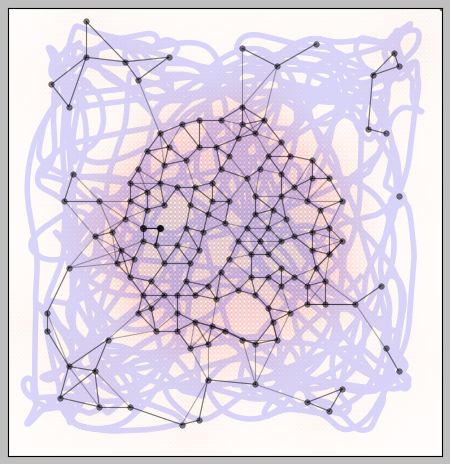

In [175]:
model.set_off()
minm.DEBUG = bool(0)


record = utils.train_whole_track(model=model, whole_track=whole_track,
                                 whole_track_layer=whole_track_layer,
                                 use_a=False)

# vis.plot_place_fields(N=model.N, trajectory=trajectory,
#                       whole_track=whole_track, record=recor d)
_ = vis.plot_fields_trajectory(record=record, whole_track=whole_track,
                               whole_track_layer=whole_track_layer,
                               trajectory=trajectory, model=model,
                               knn_k=5, max_dist=0.13)

In [ ]:
# --- ANALYSIS 2

# model_or.set_off()
# model = deepcopy(model_or)
model.set_off()
minm.DEBUG = bool(0)

record = utils.train_whole_track(model=model, whole_track=whole_track,
                                 whole_track_layer=whole_track_layer,
                                 use_a=False)

_, ax = plt.subplots()

# trajectory
ax.plot(trajectory[:, 0], trajectory[:, 1], 'b-', alpha=0.1, lw=2, label="trajectory")

centers, _ = vis.plot_centers(model=model, trajectory=whole_track_layer,
                              track=whole_track, kernel=np.ones((20)),
                              threshold=0, threshold_s=0.1,
                              ax=ax, record=record, kernel2=np.ones((4, 4)),
                              alpha=0.5, plot=True, use_knn=True,
                              knn_k=5, max_dist=0.4,
                              grid=False, color="blue")
ax.set_title(f"{len(centers)} place cells")
plt.legend()
plt.show()

old_centers = centers.copy()

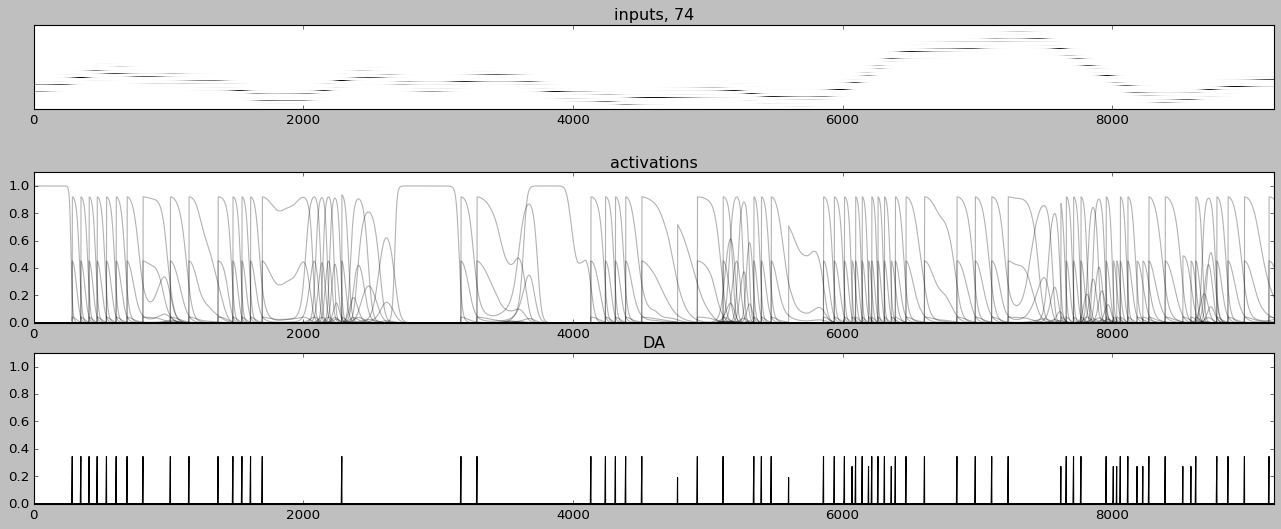

In [15]:
plt.figure(figsize=(20, 8))

plt.subplot(311)
plt.imshow(inputs.T, cmap="Greys")
plt.title(f"inputs, {model._umask.sum():.0f}")
plt.yticks(())
plt.xlim((0, len(inputs)))

plt.subplot(312)
plt.title("activations")
#plt.imshow(a, cmap="Greys")
#plt.yticks(())
for i in range(N):
    plt.plot(range(len(inputs)), a[i], 'k-', alpha=0.3)
plt.xlim((0, len(inputs)))
plt.ylim((0, 1.1))

plt.subplot(313)
plt.title("DA")
plt.plot(range(len(inputs)), da[0], 'k-')
plt.xlim((0, len(inputs)))
plt.ylim((0, 1.1))

plt.show()

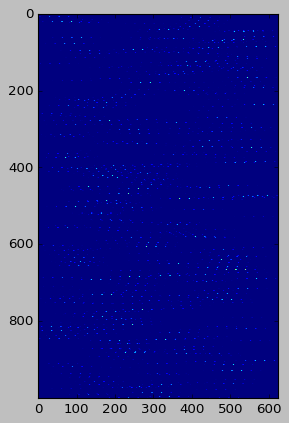

In [901]:
plt.imshow(model._Wff); plt.show()

In [ ]:
plt.imshow(model._pcnn.W_rec); plt.show()

In [893]:
model._Wff.max()

0.9952084717285828

In [818]:
np.where((1 - model._Wff.sum(axis=1)) < 0.001)[0]

array([93])

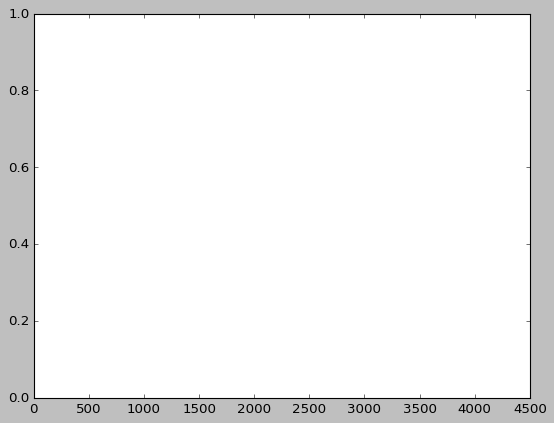

In [584]:
plt.plot(range(len(inputs)), da[0], 'k-')
plt.ylim((0, 1));

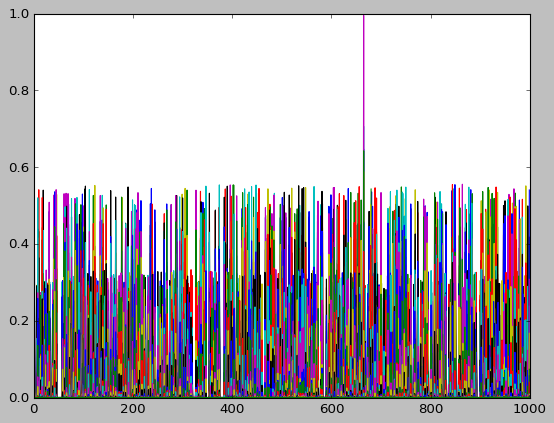

In [898]:
plt.plot(model._Wff);

In [649]:
model._umask.sum(), np.argmax(model._umask)

(1.0, 130)